<a href="https://colab.research.google.com/github/BranislavMajernik/zerocode/blob/master/MultiClassLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('npsFY21.csv')
df.head()

Saving npsFY21.csv to npsFY21 (2).csv


,ID,Comment,Type,Label
0,79171843,propose software that works correctly (see IFR...,Constructive,"Customer Care, Product"
1,80136748,"Support organisation very remote, hard to test...",Constructive,Support
2,81141131,Java has been working for years without any pr...,Positive,Product
3,81141886,do more publicity. We cannot compete with othe...,Constructive,Brand
4,81145926,"the manuals, about the different areas are unc...",Constructive,Enablement


In [ ]:
df.columns
from io import StringIO
col = ['Comment', 'Label']
df = df[col]
df = df[pd.notnull(df['Comment'])]
df.columns = ['Comment', 'Label']
df['Label']
df['category_id'] = df['Label'].factorize()[0]
category_id_df = df[['Label', 'category_id']].sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)
#print(df)

                                               Comment  ... category_id
0    propose software that works correctly (see IFR...  ...           0
1    Support organisation very remote, hard to test...  ...           1
2    Java has been working for years without any pr...  ...           2
3    do more publicity. We cannot compete with othe...  ...           3
4    the manuals, about the different areas are unc...  ...           4
..                                                 ...  ...         ...
436        improve/increase service desk response time  ...           1
437  The feeling is that in the cloud services offe...  ...          14
438                                    improve support  ...           1
439  In the field of Oracle HCM Cloud, some modules...  ...          16
440         More responsive and better quality support  ...           1

[441 rows x 3 columns]


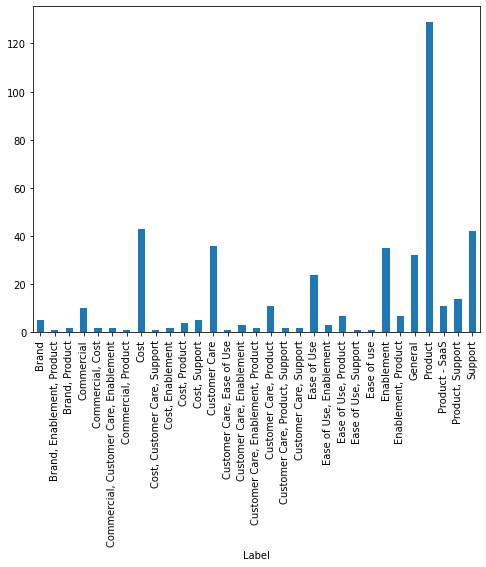

In [ ]:
# plot count of comment grouped by label
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Label').Comment.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english')
# min_df is the minimum numbers of documents a word must be present in to be kept
features = tfidf.fit_transform(df.Comment).toarray()
labels = df.category_id
#print(labels)
features.shape
# number of comments represented by number of features

0       0
1       1
2       2
3       3
4       4
       ..
436     1
437    14
438     1
439    16
440     1
Name: category_id, Length: 441, dtype: int64


(441, 146)

In [ ]:
# calculation of correlated iteresting unigrams, bigrams on training set (or any set)
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Brand':
  . Most correlated unigrams:
       . reputation
       . marketing
  . Most correlated bigrams:
       . just need
       . experience 20
# 'Brand, Enablement, Product':
  . Most correlated unigrams:
       . seminar
       . infrastracture
  . Most correlated bigrams:
       . seminar infrastracture
       . designed seminar
# 'Brand, Product':
  . Most correlated unigrams:
       . promoted
       . popularity
  . Most correlated bigrams:
       . oracle version
       . quality popularity
# 'Commercial':
  . Most correlated unigrams:
       . changing
       . orders
  . Most correlated bigrams:
       . simpler licensing
       . flexibility orders
# 'Commercial, Cost':
  . Most correlated unigrams:
       . budget
       . scam
  . Most correlated bigrams:
       . transparency like
       . costs licenses
# 'Commercial, Customer Care, Enablement':
  . Most correlated unigrams:
       . enterprises
       . profit
  . Most correlated bigrams:
       . customer satisfa

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


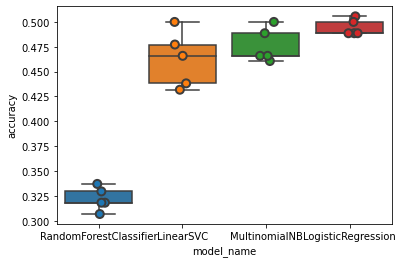

model_name
LinearSVC                 0.462640
LogisticRegression        0.494305
MultinomialNB             0.476226
RandomForestClassifier    0.321961
Name: accuracy, dtype: float64

In [ ]:
# find suitable ML model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
cv_df.groupby('model_name').accuracy.mean()


In [ ]:
# use Naive Bayes Classifier the one most suitable for word counts is the multinomial variant
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Label'], test_size=0.99 ,random_state = 4)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# test also LinearSVC
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.99, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
uploaded = files.upload()
dfo = pd.read_csv('npsFY22Q1.csv')
dfo.head()

Saving npsFY22Q1.csv to npsFY22Q1 (5).csv


,ID,Comment
0,614588,sql
1,614823,Return of simple graphic database managers lik...
2,615036,valid product consolidated and always innovative
3,615271,Flexible price for services in Russia. Medium ...
4,615335,Performance


In [ ]:

X_test=dfo['Comment'] 
X_vector=count_vect.transform(X_test) #converting X_test to vector
y_predict = clf.predict(X_vector)     #use the trained model on X_vector
y_prob = clf.predict_proba(X_vector)[:,1] #calculate probability of trained model on X_vector
#print('{name}: {value}'.format(name=y_prob, value=y_predict))
#dfo['predict_prob']= y_prob
dfo['Label']= y_predict
dfo.to_csv('Labeld_npsFY22Q1.csv')

